# Example: a coarse-grained (CG) model for BmimPF$_6$-ACN mixture

* The CG model for BmimPF$_6$ is from [J. Phys. Chem. B 2010, 114, 39, 12629](https://pubs.acs.org/doi/10.1021/jp108179n)
* The CG model for ACN is from [Mol. Phys. 1984, 51, 1141](https://doi.org/10.1080/00268978400100731)
* The mixutre represented by these two models has been used in [J. Phys. Chem. C 2020, 124, 5515](https://doi.org/10.1021/acs.jpcc.9b10428) and [Phys. Rev. Lett. 2022, 128, 38](https://doi.org/10.1103/PhysRevLett.128.086001)

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
pd.options.display.max_rows = 6
pd.options.display.max_columns = None
pd.options.display.width = 100
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import MDAnalysis as mda
from MDAnalysis import transformations
import nglview as nv

from scipy.ndimage import gaussian_filter

import os,re

%run -i _functions.py

## build intial configuration

### create intial simulaiton box

* ```*.zmat``` and ```*.ff``` contains the information for the CG models.
* using ```fftool``` and ```packmol``` to generate the intial simulaiton box.
* a cubic simlation box with edges of $4.5$ nm and $935$ ACN molecules plus $65$ pairs of BmimPF$_6$ is created.

In [2]:
lx = ly = lz = 45
ACN_num = 935
cation_num = anion_num = 65
!fftool $ACN_num ACN.zmat $cation_num c4c1im.zmat $anion_num PF6.zmat -b $lx,$ly,$lz -c -t 3

density 19.408 mol/L  volume 91125.0 A^3
molecule_file      species           nmol force_field      nbond source  charge
  ACN.zmat         ACN                935 ACN.ff               2 file   +0.0000
  c4c1im.zmat      c4c1im+             65 il.ff                2 file   +0.7800
  PF6.zmat         PF6-                65 il.ff                0 file   -0.7800
packmol file
  pack.inp


In [3]:
%%capture
filename = './simbox.xyz'
if os.path.isfile(filename): os.remove(filename)
! packmol < pack.inp
!fftool $ACN_num ACN.zmat $cation_num c4c1im.zmat $anion_num PF6.zmat -b $lx,$ly,$lz -c -t 3 -l

### visulize the inital configuration¶

In [4]:
u = mda.Universe('simbox.xyz')
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_unitcell()
view.add_representation(repr_type='licorice',radius='1',opacity=1)
view.camera = 'orthographic'
view.control.spin([1,0,0],-np.pi/2.)
view

NGLWidget()

In [5]:
view.render_image(factor=8,antialias=True,trim=True,transparent=True)

Image(value=b'', width='99%')

![image.png](./images/init_box.png)

## run simulaitons
* run LAMMPS simulations with ```input_mixture.lmp``` to equlibrate the system.

## data analysis and visulization

* we can use info. in ```data.lmp``` generated by ```fftool``` to determin the element fot the atom types in LAMMPS

In [6]:
directory = './'
filename = directory+'data.lmp'
##elements
elements = fetchList(filename, 'Masses', 0,4, skipBlankSplit=True)
digitspattern = r'#'
types = []
chemical_symbols = []
for element in elements:
    types.append(int(element[0]))
    txt = re.sub(digitspattern, '', element[-1])
    chemical_symbols.append(atomic_symbol(txt))
types = np.array(types)

print('types:            ',types)
print('chemical_symbols: ',chemical_symbols)

types:             [1 2 3 4 5 6 7]
chemical_symbols:  ['N', 'C', 'C', 'C', 'N', 'C', 'P']


### vilulize the simulated system
* only a few frames are saved here.

In [7]:
ACN_num=935;cation_num = anion_num = 65

#full: atom-ID molecule-ID atom-type q x y z
u = mda.Universe('result_atoms.data', atom_style='id resid type charge x y z')
## elements
elements = []
for i in range(len(u.atoms)):
    elements.append(chemical_symbols[np.where(types==int(u.atoms[i].type))[0][0]])
u.add_TopologyAttr('element',values=elements)

## resnames
resnames = ['ACN']*ACN_num+['cati']*cation_num+['anio']*anion_num #+['co2']*co2_num
u.add_TopologyAttr('resnames',values=resnames)

u.load_new("result_atoms.lammpstrj", format="LAMMPSDUMP",timeunit="fs",dt=10000)
workflow = [transformations.unwrap(u.atoms)]
u.trajectory.add_transformations(*workflow)

print('dimensions:',u.dimensions)
print('frames',u.trajectory.n_frames)


view = nv.show_mdanalysis(u)

view.clear_representations()
view.add_representation(selection='ACN',repr_type='licorice',radius='1',opacity=0.4,color='white')
view.add_representation(selection='cati',repr_type='licorice',radius='1',opacity=1,color='orange')
view.add_representation(selection='anio',repr_type='licorice',radius='1',opacity=1,color='green')
#view.add_unitcell()
view.camera = 'orthographic'
view.control.spin([1,0,0],-np.pi/2.)
view

dimensions: [45. 45. 45. 90. 90. 90.]
frames 6


NGLWidget(max_frame=5)

In [10]:
view.render_image(factor=8,antialias=True,trim=True,transparent=True)

Image(value=b'', width='99%')

![image.png](./images/eq_box.png)

* you can save trajectory in ```xyz``` formate to visulize in other software like VMD.

In [9]:
if 0:
    with mda.Writer('result_atoms.xyz',len(u.atoms),bonds='all') as w:
        #for ts in u.trajectory[-1]:
        w.write(u)

#### plot the system thermo. properties *vs.* time

average: 299.980 +- 4.980
average: 0.192 +- 140.255
average: 46.907 +- 0.181


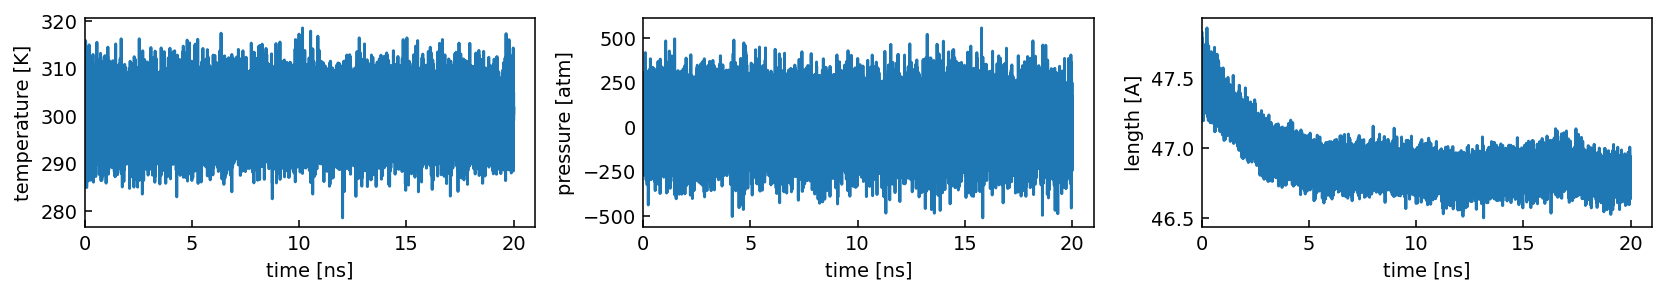

In [10]:
filename = 'result_thermo.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']
data['time'] /= 1e6
start = 10

fig = plt.figure(figsize=(12,2.2), dpi=140);
ax = fig.add_subplot(131);

x = data.loc[start:,'time'] 
y = data.loc[start:,'temp'] 
ax.plot(x,y,'-');
print('average: %.3f +- %.3f' %(np.mean(y.values),np.std(y.values)))
y = data.loc[100:,'ACN_con'] 
#ax.plot(x,y,'-');

ax.set_xlabel(r'time [ns]');
ax.set_ylabel(r'temperature [K]');
ax.set_xlim(0,);
#ax.set_ylim(0,);
ax.tick_params(direction='in')

ax = fig.add_subplot(132);

y = (data.loc[start:,'pxx']+data.loc[start:,'pyy'] +data.loc[start:,'pzz'])/3
ax.plot(x,y,'-');
print('average: %.3f +- %.3f' %(np.mean(y.values),np.std(y.values)))

ax.set_xlabel(r'time [ns]');
ax.set_ylabel(r'pressure [atm]');
ax.set_xlim(0,);
#ax.set_ylim(0,);
ax.tick_params(direction='in')

ax = fig.add_subplot(133);

y = data.loc[start:,'lz']
ax.plot(x,y,'-');
print('average: %.3f +- %.3f' %(np.mean(y.values),np.std(y.values)))

ax.set_xlabel(r'time [ns]');
ax.set_ylabel(r'length [A]');
ax.set_xlim(0,);
#ax.set_ylim(0,);
ax.tick_params(direction='in')


plt.tight_layout()
plt.show()  

### caluclate the average molar concenation of species

average: 1.052    0.006
average: 15.129    0.082
average: 0.920    0.005


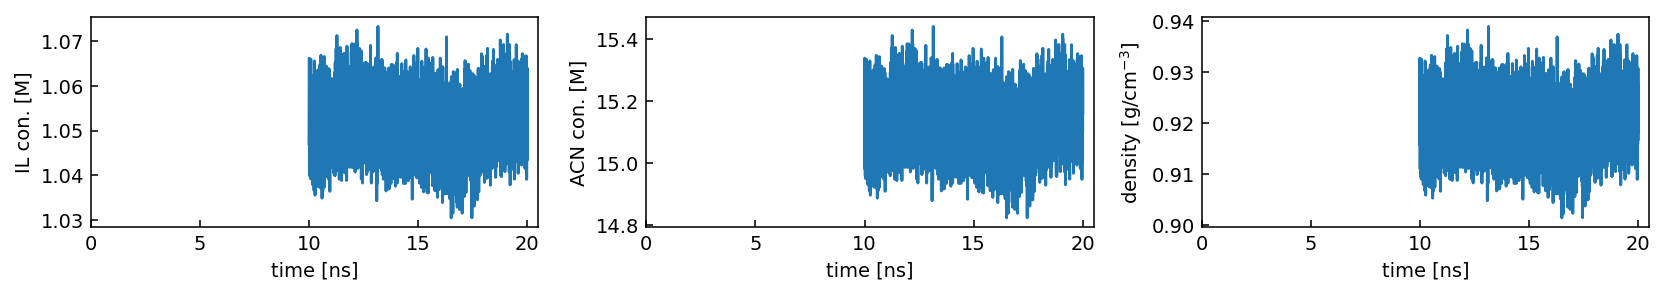

In [11]:
filename = 'result_thermo.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']
data['time'] /= 1e6
start = 10000

fig = plt.figure(figsize=(12,2.2), dpi=140);
ax = fig.add_subplot(131);

x = data.loc[start:,'time'] 
y = data.loc[start:,'IL_con'] 
ax.plot(x,y,'-');
print('average: %.3f    %.3f' %(np.mean(y.values),np.std(y.values)))
y = data.loc[100:,'ACN_con'] 
#ax.plot(x,y,'-');

ax.set_xlabel(r'time [ns]');
ax.set_ylabel(r'IL con. [M]');
ax.set_xlim(0,);
#ax.set_ylim(0,);
ax.tick_params(direction='in')

ax = fig.add_subplot(132);

y = data.loc[start:,'ACN_con'] 
ax.plot(x,y,'-');
print('average: %.3f    %.3f' %(np.mean(y.values),np.std(y.values)))

ax.set_xlabel(r'time [ns]');
ax.set_ylabel(r'ACN con. [M]');
ax.set_xlim(0,);
#ax.set_ylim(0,);
ax.tick_params(direction='in')

ax = fig.add_subplot(133);

y = data.loc[start:,'density'] 
ax.plot(x,y,'-');
print('average: %.3f    %.3f' %(np.mean(y.values),np.std(y.values)))

ax.set_xlabel(r'time [ns]');
ax.set_ylabel(r'density [g/cm$^{-3}$]');
ax.set_xlim(0,);
#ax.set_ylim(0,);
ax.tick_params(direction='in')

plt.tight_layout()
plt.show()  